# Step 0: Import Libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(style="white")
%matplotlib inline

# Step 1: Read the Dataset

In [5]:
df = pd.read_csv("clean_lem_stemmed_train_data.csv")

In [6]:
df.head()

,Unnamed: 0,qid,question_text,target
0,0,00002165364db923c7e6,how did quebec nationalists see their province...,0
1,1,000032939017120e6e44,do you have an adopted dog how would you encou...,0
2,2,0000412ca6e4628ce2cf,why does velocity affect time does velocity af...,0
3,3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0
4,4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Unnamed: 0     1306122 non-null  int64 
 1   qid            1306122 non-null  object
 2   question_text  1306121 non-null  object
 3   target         1306122 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 39.9+ MB


# Step 2: Preprocessing / Cleaning Data

## A. Rows:
- Check missing
- Check Null Value
- Check Formats
- Check Duplicates
- Check Data Ranges
- Clean text (remove numbers, punctuations,stop words and convert to lowercase)

In [ ]:
# Check total number of missing cells
df.isna().sum()

Unnamed: 0       0
qid              0
question_text    1
target           0
dtype: int64

In [ ]:
# Check Missing Percentage in each column
round((df.isna().sum() / 1306122)* 100, 5)

Unnamed: 0       0.00000
qid              0.00000
question_text    0.00008
target           0.00000
dtype: float64

In [7]:
# double check for missing 
df.replace(["#","*",'NA','N/A','?',''],np.nan).isna().sum()

Unnamed: 0       0
qid              0
question_text    1
target           0
dtype: int64

In [ ]:
df.question_text.isna().sum()
# there a missing in question_text column

1

In [ ]:
# We found the missing value in row number 420816 
null_data = df[df.isna().any(axis=1)]
null_data 

,Unnamed: 0,qid,question_text,target
420816,420816,527aac2ce6f12f789fe5,NaN,1


In [ ]:
# We found the null value in row number 420816 
null_data = df[df.isnull().any(axis=1)]
null_data 

,Unnamed: 0,qid,question_text,target
420816,420816,527aac2ce6f12f789fe5,NaN,1


In [8]:
# We create null_data to remove the missing value from our dataset
null_data = df.drop(labels=420816, axis=0)
null_data

,Unnamed: 0,qid,question_text,target
0,0,00002165364db923c7e6,how did quebec nationalists see their province...,0
1,1,000032939017120e6e44,do you have an adopted dog how would you encou...,0
2,2,0000412ca6e4628ce2cf,why does velocity affect time does velocity af...,0
3,3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0
4,4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0
...,...,...,...,...
1306117,1306117,ffffcc4e2331aaf1e41e,what other technical skills do you need as a c...,0
1306118,1306118,ffffd431801e5a2f4861,does ms in ece have good job prospects in usa ...,0
1306119,1306119,ffffd48fb36b63db010c,is foam insulation toxic,0
1306120,1306120,ffffec519fa37cf60c78,how can one start a research project based on ...,0


In [9]:
# check for missing again
null_data.isna().sum()

Unnamed: 0       0
qid              0
question_text    0
target           0
dtype: int64

In [ ]:
# check format
null_data.dtypes

Unnamed: 0        int64
qid              object
question_text    object
target            int64
dtype: object

In [ ]:
# Check duplicates
null_data.duplicated().sum()

0

In [10]:
# Check duplicates for question text 
null_data.question_text.duplicated().sum()

1385

In [11]:
# Remove duplicates from question_text
null_data.drop_duplicates(subset='question_text', keep='first', inplace=True)

In [12]:
# Check duplicates for question text 
null_data.question_text.duplicated().sum()

0

In [ ]:
# Check Data Ranges 
# A. Numeric
null_data.describe()

,Unnamed: 0,target
count,1.306121e+06,1.306121e+06
mean,6.530607e+05,6.186946e-02
std,3.770452e+05,2.409184e-01
min,0.000000e+00,0.000000e+00
25%,3.265300e+05,0.000000e+00
50%,6.530610e+05,0.000000e+00
75%,9.795910e+05,0.000000e+00
max,1.306121e+06,1.000000e+00


In [ ]:
# A. Categoricals
round(null_data.describe(exclude = "number"))

,qid,question_text
count,1306122,1306121
unique,1306122,1304736
top,00002165364db923c7e6,what is
freq,1,129


In [13]:
# add a new column
null_data['qtype'] = np.where(null_data['target'] == 1, 'insincere', 'sincere')
null_data.head()

,Unnamed: 0,qid,question_text,target,qtype
0,0,00002165364db923c7e6,how did quebec nationalists see their province...,0,sincere
1,1,000032939017120e6e44,do you have an adopted dog how would you encou...,0,sincere
2,2,0000412ca6e4628ce2cf,why does velocity affect time does velocity af...,0,sincere
3,3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0,sincere
4,4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0,sincere


In [14]:
# Include only the quetion text and question type
null_data1 = null_data[['question_text', 'qtype']]
null_data1.head()

,question_text,qtype
0,how did quebec nationalists see their province...,sincere
1,do you have an adopted dog how would you encou...,sincere
2,why does velocity affect time does velocity af...,sincere
3,how did otto von guericke used the magdeburg h...,sincere
4,can i convert montra helicon d to a mountain b...,sincere


In [ ]:
# the dataset has mostly sincere questions
null_data1.qtype.value_counts(normalize=True)

sincere      0.938131
insincere    0.061869
Name: qtype, dtype: float64

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
english = stopwords.words('english')

In [18]:
porter_stemmer = PorterStemmer()

In [19]:
# create a new column to hold clean text 
# to remove numbers, punctuations,stop words and convert to lowercase
import re

def text_cleaner(text):
    word_tokens = word_tokenize(text)
    tokens = [porter_stemmer.stem(w.lower()) for w in word_tokens if w not in english]
    clean_qtext = " ".join(tokens) + ' '
    clean_qtext = re.sub(" \d+", " ", clean_qtext)
    return clean_qtext

null_data1 = null_data1
null_data1['clean_qtext'] = null_data1['question_text'].apply(text_cleaner)
null_data1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,question_text,qtype,clean_qtext
0,how did quebec nationalists see their province...,sincere,quebec nationalist see provinc nation
1,do you have an adopted dog how would you encou...,sincere,adopt dog would encourag peopl adopt shop
2,why does velocity affect time does velocity af...,sincere,veloc affect time veloc affect space geometri
3,how did otto von guericke used the magdeburg h...,sincere,otto von guerick use magdeburg hemispher
4,can i convert montra helicon d to a mountain b...,sincere,convert montra helicon mountain bike chang tyre


## B. Columns
- Drop un-necessary columns
- Remove white spaces 
- Reindex tha dataset

In [20]:
# Drop un-necessary columns 
# Since we already have clean question text we do not need question text, shall be dropped!
null_data1 = null_data1.drop(columns = 'question_text')

In [21]:
# remove white spaces
null_data1.columns = null_data1.columns.str.strip()

In [22]:
# reindex the dataset
column_names= ["clean_qtext", "qtype"]
null_data1= null_data1.reindex(columns=column_names)

In [23]:
null_data1.head(1)

,clean_qtext,qtype
0,quebec nationalist see provinc nation,sincere


# Step 3: Explore Data (EDA)

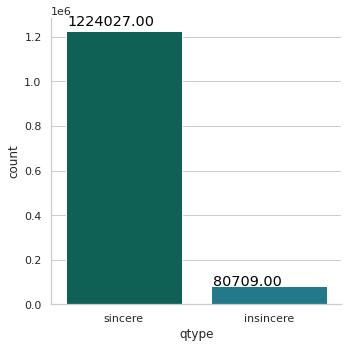

In [24]:
# Check Target --> qtype (balanced or not??)
sns.set_theme(style='whitegrid', palette = "PuBuGn_r")
g= sns.catplot(x='qtype', data= null_data1, kind='count');
ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.015, 
            p.get_height() * 1.02, 
            '{0:.2f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

### Based on the graph above it shows that sincere questions is much more than insincere questions, so it is imbalanced.

In [25]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

## Word Cloud for most Frequent words !!

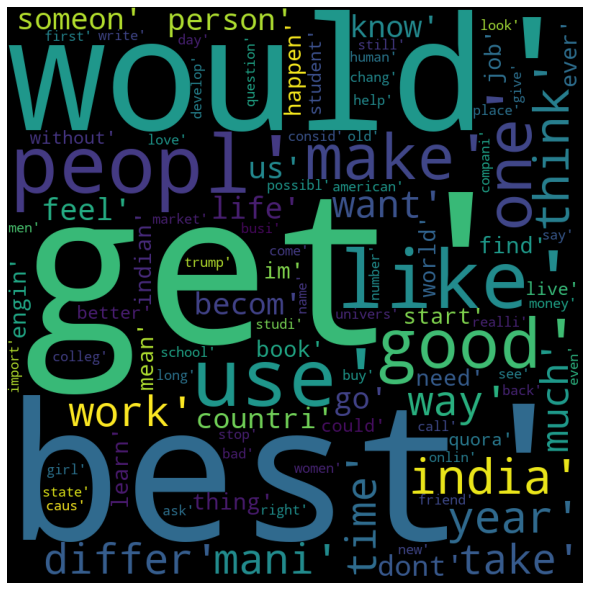

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

def most_freq_words (data, column, numWords):
    topic_words = [z.lower() for y in [x.split() for x in data[column] if isinstance (x,str)] for z in y
                  ]
    word_count_dict = dict(Counter(topic_words))
    popular_words  = sorted(word_count_dict, key = word_count_dict.get, reverse=True)
    popular_words_nonstop = [ w for w in popular_words if w not in english ]
    word_string = str(popular_words_nonstop)
 #     print(topic_words)
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black', # can chanage background color
                stopwords = english,
                min_font_size = 10,
                max_words = numWords).generate(word_string)
 
 # plot the WordCloud image

    plt.clf()
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
# Here below we use the above word cloud function to present word frequency in documents
# ALso we can choose the number of words to be presented 
plt.figure(most_freq_words(null_data1, 'clean_qtext', 100))

# Step 4: Modeling

## Prepare data for modeling

In [27]:
# Split the data into X and y data sets
X = null_data1.clean_qtext
y = null_data1.qtype

In [28]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(max_features = 300)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,abl,accept,account,act,actual,affect,age,allow,also,alway,america,american,anim,anoth,answer,anyon,app,appli,applic,around,ask,back,bad,bank,base,becom,believ,benefit,best,better,big,black,bodi,book,build,busi,buy,call,canada,cant,...,thing,think,time,today,top,train,travel,tri,true,trump,two,type,unit,univers,us,usa,use,valu,video,view,want,war,watch,water,way,websit,well,what,white,win,without,woman,women,word,work,world,would,write,wrong,year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, max_features = 300)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,abl,accept,account,act,actual,affect,age,allow,also,alway,america,american,anim,anoth,answer,anyon,app,appli,applic,around,ask,back,bad,bank,base,becom,believ,benefit,best,best way,better,big,black,bodi,book,build,busi,buy,call,canada,...,think,time,today,top,train,travel,tri,true,trump,two,type,unit,univers,us,usa,use,valu,video,view,want,war,watch,water,way,websit,well,what,white,win,without,woman,women,word,work,world,would,write,wrong,year,year old
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Try classifying using Logistic Regression

In [31]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [32]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [33]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [34]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

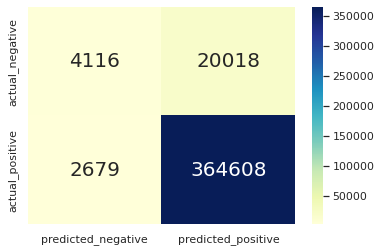

In [35]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

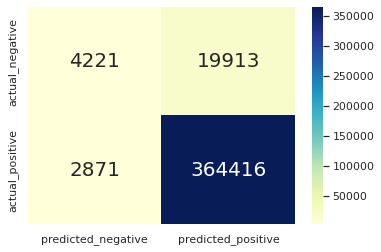

In [36]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [37]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.942,0.942
Precision,0.948,0.948
Recall,0.993,0.992
F1 Score,0.970,0.970


LogReg1 and LogReg2 have the same Accuracy and Precision, but LogReg1 has better recall.



## Try classifying using Naive Bayes


In [38]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [39]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

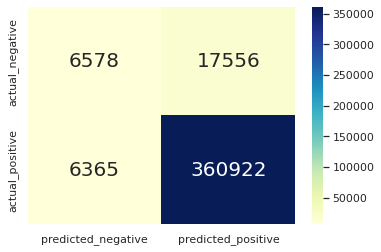

In [40]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

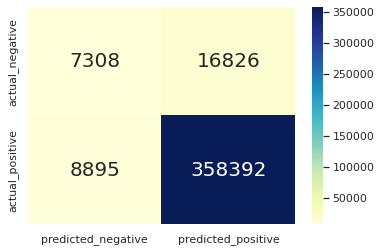

In [41]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [42]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

,LogReg1,LogReg2,NB1,NB2
Accuracy,0.942,0.942,0.939,0.934
Precision,0.948,0.948,0.954,0.955
Recall,0.993,0.992,0.983,0.976
F1 Score,0.970,0.970,0.968,0.965


The second Naive Bayes model has better precision of both Logistic Regression models.


## Try using TF-IDF instead of Count Vectorizer

In [43]:
# Create TF-IDF versions of the Count Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(max_features = 300)
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, max_features = 300)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

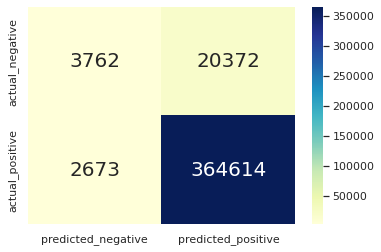

In [44]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

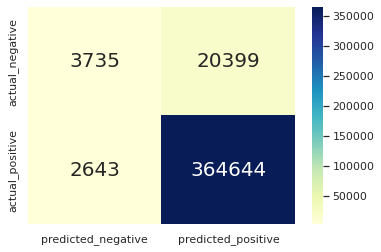

In [45]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

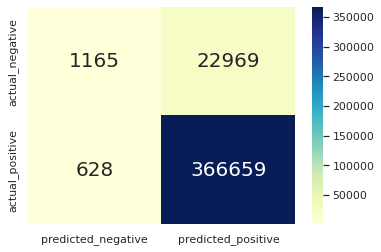

In [46]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

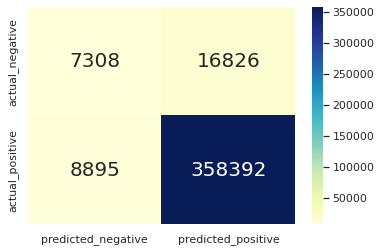

In [47]:
# Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [48]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

,LogReg1,LogReg2,NB1,NB2,LR1-TFIDF,LR2-TFIDF,NB1-TFIDF,NB2-TFIDF
Accuracy,0.942,0.942,0.939,0.934,0.941,0.941,0.940,0.934
Precision,0.948,0.948,0.954,0.955,0.947,0.947,0.941,0.955
Recall,0.993,0.992,0.983,0.976,0.993,0.993,0.998,0.976
F1 Score,0.970,0.970,0.968,0.965,0.969,0.969,0.969,0.965


Using TF-IDF have improve the recall, but the accuracy and precision of the first logistic regression model still outperforms the other models.

In [49]:
# Split the data into X and y data sets
X = null_data1.clean_qtext
y = null_data1.qtype

In [50]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.lancaster import LancasterStemmer

stemmer = LancasterStemmer()
analyzer = CountVectorizer(max_features = 300).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stem_vectorizer = CountVectorizer(analyzer=stemmed_words)

X_train_cv1 = stem_vectorizer.fit_transform(X_train)
X_test_cv1  = stem_vectorizer.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=stem_vectorizer.get_feature_names()).head()

## Try classifying using Logistic Regression

In [ ]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [ ]:
# The heat map for the first logistic regression model
cm9 = conf_matrix(y_test, y_pred_cv1)

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm9)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR9-CV']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

In [ ]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.lancaster import LancasterStemmer

stemmer = LancasterStemmer()
analyzer = TfidfVectorizer(max_features = 300).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stem_vectorizer = TfidfVectorizer(analyzer=stemmed_words)

X_train_cv1 = stem_vectorizer.fit_transform(X_train)
X_test_cv1  = stem_vectorizer.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=stem_vectorizer.get_feature_names()).head()

In [ ]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [ ]:
# The heat map for the first logistic regression model
cm10 = conf_matrix(y_test, y_pred_cv1)

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm10)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR10-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results